### Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller

### Create Artifical data

In [3]:
xvalues = np.linspace(0,2*np.pi*41,1000)
offset = 2
noiselevel = 0.1
sinusoidal_trend_1 = np.sin(xvalues)
sinusoidal_trend_2 = np.sin(xvalues*0.3)
linear_trend = np.linspace(0,0,1000)
noise = np.random.randn(1000)
signal = linear_trend + sinusoidal_trend_2 + sinusoidal_trend_1 + offset + noise*noiselevel

### White Noise

In [4]:
noise = np.random.randn(1000)

### Load Real World Datasets

In [5]:
daily_demand = pd.read_csv('../../data/time_series/daily_demand.csv',delimiter=';')
female_births = pd.read_csv('../../data/time_series/daily-total-female-births.csv')
airline_passengers = pd.read_csv('../../data/time_series/airline-passengers.csv')
energy_consumption = pd.read_csv('../../data/time_series/energy_consumption.csv')
consumption = energy_consumption['Consumption'].values
births = female_births['Births'].values
passengers = airline_passengers['Passengers']
daily_demand = daily_demand[['Banking orders (3)']].values

### Combine datasets

In [30]:
datasets = {}
# datasets['consumption'] = consumption[::30]
# datasets['births'] = births
# datasets['passengers'] = passengers
# datasets['daily_demand'] = daily_demand
datasets['signal'] = signal

### Models

signal
ADF Statistic: -12.278466
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.11534D-02    |proj g|=  1.19165D+00

At iterate    5    f= -6.07416D-02    |proj g|=  2.56375D-01

At iterate   10    f= -1.10531D-01    |proj g|=  2.95455D-01


 This problem is unconstrained.



At iterate   15    f= -1.78203D-01    |proj g|=  1.81133D-01

At iterate   20    f= -1.86932D-01    |proj g|=  2.10507D-01

At iterate   25    f= -1.88757D-01    |proj g|=  6.30000D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   3.775D-06  -1.888D-01
  F = -0.18875675722933202     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


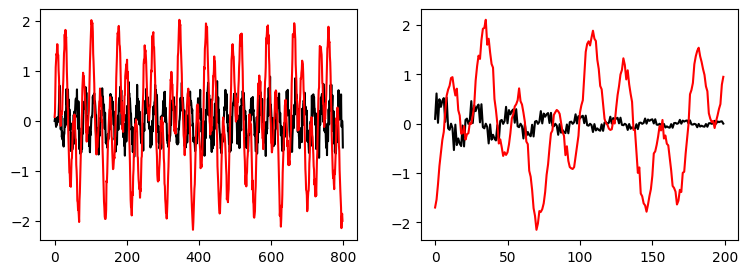

In [31]:
for key in datasets.keys():

    #Get Data
    print(key)
    data = datasets[key]
    data = data - np.mean(data)
    data = data / np.std(data)    
    split = int(len(data) * 0.8)
    train_data = data[:split]
    test_data = data[split:]
    
    #Test for Stationarity
    result = adfuller(train_data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))    
    print('')    
    
    #Determine the number of lags of the model
    vals,conf = pacf(train_data,alpha=.05)
    lower = (conf[:,0] < 0)*1.0
    upper = (conf[:,1] > 0)*1.0
    total = lower + upper
    for i in range(len(total)):
        if (total[i] > 1):
            no_lags = i-1
            break;

    model = sm.tsa.statespace.SARIMAX(train_data, trend='c', order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=True).fit()
    #print('Number of Lags: ' + str(no_lags))
    
    #Predict
    plt.figure(figsize=(9,3))
    plt.subplot(1,2,1)
    pred = model.predict(start=0, end=len(train_data), dynamic=False)
    plt.plot(pred,'k')
    plt.plot(train_data,'r')
    
    #Forecast
    plt.subplot(1,2,2)
    no_forecasting_steps = len(test_data)
    fcast = model.forecast(steps=no_forecasting_steps)
    plt.plot(fcast,'k')
    plt.plot(test_data,'r')
    #print(model.summary())
    

In [10]:
help(sm.tsa.ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima.model:

class ARIMA(statsmodels.tsa.statespace.sarimax.SARIMAX)
 |  ARIMA(endog, exog=None, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, enforce_stationarity=True, enforce_invertibility=True, concentrate_scale=False, trend_offset=1, dates=None, freq=None, missing='none', validate_specification=True)
 |  
 |  Autoregressive Integrated Moving Average (ARIMA) model, and extensions
 |  
 |  This model is the basic interface for ARIMA-type models, including those
 |  with exogenous regressors and those with seasonal components. The most
 |  general form of the model is SARIMAX(p, d, q)x(P, D, Q, s). It also allows
 |  all specialized cases, including
 |  
 |  - autoregressive models: AR(p)
 |  - moving average models: MA(q)
 |  - mixed autoregressive moving average models: ARMA(p, q)
 |  - integration models: ARIMA(p, d, q)
 |  - seasonal models: SARIMA(P, D, Q, s)
 |  - regression with errors that follow one of the above ARIM

In [1]:
sm.tsa.SARIMA

NameError: name 'sm' is not defined